## Setup

In [ ]:
!pip install -U -q imgaug --user

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers 

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from imgaug import augmenters as iaa
import imgaug as ia
ia.seed(42)

from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


## Load the CIFAR10 dataset

For this example, we will be using the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Define hyperparameters

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 512 
EPOCHS = 100

## Initialize `RandAugment` object

In [ ]:
rand_aug = iaa.RandAugment(n=3, m=7)

def augment(images):
    # Input to `augment()` is a TensorFlow tensor which
    # is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

## Create TensorFlow `Dataset` objects

In [ ]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (72, 72)), y),
        num_parallel_calls=AUTO,
    )
    # The returned output of `tf.py_function` contains an unncessary axis of
    # 1-D and we need to remove it.
    .map(
        lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(lambda x, y: (tf.image.resize(x, (72, 72)), y),
        num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

For comparison purposes, let's also define a simple augmentation pipeline consisting of random flips, random rotations, and random zoomings. 

In [ ]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(72, 72),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE*100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y),
                            num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

## Visualize the dataset augmented with RandAugment

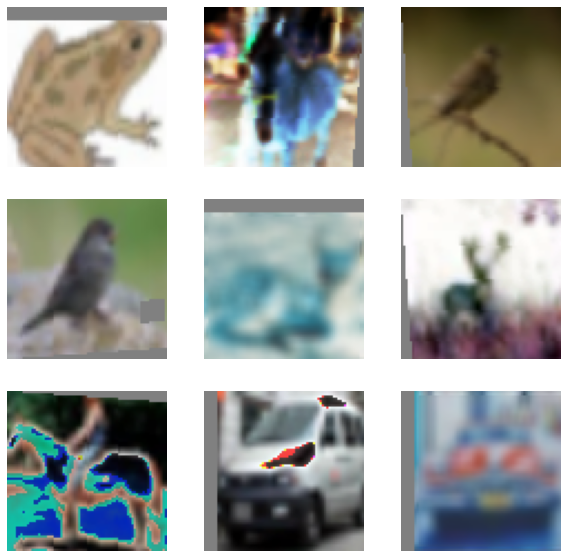

In [ ]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## Visualize the dataset augmented with `simple_aug`

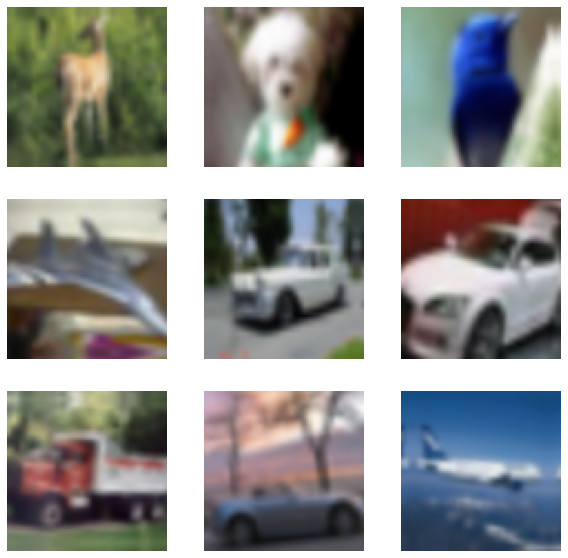

In [ ]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## Define a model building utility function

In [ ]:
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None, include_top=True, input_shape=(72, 72, 3),
        classes=10
    )
    model = tf.keras.Sequential([
        layers.Input((72, 72, 3)),
        layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1),
        resnet50_v2,
        layers.Activation("linear", dtype="float32")
    ])
    return model

get_training_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 72, 72, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 10)                23585290  
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 23,585,290
Trainable params: 23,539,850
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
# For reproducibility, we first serialize the initialize weights
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [ ]:
# We also set up an early stopping callback to prevent the models
# from overfitting
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

## 1. Train model with RandAugment

In [ ]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial_weights.h5")
rand_aug_model.compile(loss="sparse_categorical_crossentropy", 
                      optimizer="adam", 
                      metrics=["accuracy"])
rand_aug_model.fit(train_ds_rand,
        validation_data=test_ds,
        epochs=EPOCHS,
        callbacks=[es])
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc*100))

Epoch 1/100
98/98 [==============================] - 85s 705ms/step - loss: 3.1592 - accuracy: 0.1834 - val_loss: nan - val_accuracy: 0.1045
Epoch 2/100
98/98 [==============================] - 69s 653ms/step - loss: 1.7934 - accuracy: 0.3600 - val_loss: 7.4934 - val_accuracy: 0.1491
Epoch 3/100
98/98 [==============================] - 68s 646ms/step - loss: 1.8542 - accuracy: 0.3434 - val_loss: nan - val_accuracy: 0.1157
Epoch 4/100
98/98 [==============================] - 68s 640ms/step - loss: 1.7277 - accuracy: 0.3930 - val_loss: 4.5487 - val_accuracy: 0.2414
Epoch 5/100
98/98 [==============================] - 71s 626ms/step - loss: 1.6077 - accuracy: 0.4401 - val_loss: 1.5698 - val_accuracy: 0.4525
Epoch 6/100
98/98 [==============================] - 68s 643ms/step - loss: 1.5469 - accuracy: 0.4623 - val_loss: 2.3275 - val_accuracy: 0.2820
Epoch 7/100
98/98 [==============================] - 69s 645ms/step - loss: 1.5825 - accuracy: 0.4494 - val_loss: 1.4070 - val_accuracy: 0.505

In [ ]:
rand_aug_model.save("rand_aug_model")

INFO:tensorflow:Assets written to: rand_aug_model/assets


## 2. Train model with `simple_aug`

In [ ]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial_weights.h5")
simple_aug_model.compile(loss="sparse_categorical_crossentropy", 
                      optimizer="adam", 
                      metrics=["accuracy"])
simple_aug_model.fit(train_ds_simple,
        validation_data=test_ds,
        epochs=EPOCHS,
        callbacks=[es])
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc*100))

Epoch 1/100
98/98 [==============================] - 28s 202ms/step - loss: 2.3730 - accuracy: 0.2644 - val_loss: 7.0031 - val_accuracy: 0.1286
Epoch 2/100
98/98 [==============================] - 19s 183ms/step - loss: 1.2847 - accuracy: 0.5453 - val_loss: 1.7744 - val_accuracy: 0.4162
Epoch 3/100
98/98 [==============================] - 19s 181ms/step - loss: 1.0809 - accuracy: 0.6203 - val_loss: nan - val_accuracy: 0.0737
Epoch 4/100
98/98 [==============================] - 19s 183ms/step - loss: 0.9696 - accuracy: 0.6610 - val_loss: 1.0999 - val_accuracy: 0.6323
Epoch 5/100
98/98 [==============================] - 19s 183ms/step - loss: 0.9832 - accuracy: 0.6644 - val_loss: nan - val_accuracy: 0.1006
Epoch 6/100
98/98 [==============================] - 19s 183ms/step - loss: 1.0794 - accuracy: 0.6355 - val_loss: 12.5741 - val_accuracy: 0.1205
Epoch 7/100
98/98 [==============================] - 19s 182ms/step - loss: 0.8914 - accuracy: 0.6890 - val_loss: 0.8805 - val_accuracy: 0.70

In [ ]:
simple_aug_model.save("simple_aug_model")

INFO:tensorflow:Assets written to: simple_aug_model/assets


## Load the CIFAR-10-C dataset and evaluate performance

In [ ]:
# Load and prepare the CIFAR-10-C dataset
# (If it's not already downloaded, it takes ~10 minutes of time to download)
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", 
                      as_supervised=True)
cifar_10_c = (
    cifar_10_c
    .batch(BATCH_SIZE)
    .map(lambda x, y: (tf.image.resize(x, (72, 72)), y),
        num_parallel_calls=AUTO))

Dataset cifar10_corrupted downloaded and prepared to /home/jupyter/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Evaluate `rand_aug_model`
_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print("Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(test_acc*100))

# Evaluate `simple_aug_model`
_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print("Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(test_acc*100))

Accuracy with RandAugment on CIFAR-10-C (saturate_5): 76.64%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 64.80%
